In [ ]:
!pip install polars


Load Githb Code Haskell Function dataset

In [ ]:
import polars as pl

splits = {
    'train': 'hf://datasets/blastwind/deprecated-github-code-haskell-function/data/train-*-of-*.parquet',
    'test': 'hf://datasets/blastwind/deprecated-github-code-haskell-function/data/test-*-of-*.parquet',
    'valid': 'hf://datasets/blastwind/deprecated-github-code-haskell-function/data/valid-00000-of-00001-636cb804972d8982.parquet'
}


df = pl.read_parquet(splits['train'])



Create Tokenizer

In [4]:
import pickle

class CustomTokenizer:
    def __init__(self, oov_token="<UNK>"):
        self.word_to_id = {}
        self.id_to_word = {}
        self.oov_token = oov_token

        self.word_to_id[oov_token] = 0
        self.word_to_id["<start>"] = 1;
        self.word_to_id["<end>"] = 2;
        self.id_to_word[0] = oov_token
        self.id_to_word[1] = "<start>"
        self.id_to_word[2] = "<end>"

    def load(self, word_list):
        word_list = [word.lower() for word in word_list]
        next_id = max(self.word_to_id.values()) + 1

        for word in word_list:
            if word not in self.word_to_id:
                self.word_to_id[word] = next_id
                self.id_to_word[next_id] = word
                next_id += 1

    def encode(self, text):
        words = text.lower().split()
        return [self.word_to_id.get(word, self.word_to_id[self.oov_token]) for word in words]

    def decode(self, ids):
        return ' '.join(self.id_to_word.get(i, self.oov_token) for i in ids)

    def export(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump((self.word_to_id, self.id_to_word), f)

    def import_mappings(self, filename):
        with open(filename, 'rb') as f:
            self.word_to_id, self.id_to_word = pickle.load(f)


In [5]:
import pandas as pd
dataframe = pd.read_csv('data-small.csv')
tokenizer = CustomTokenizer()
dataframe = dataframe.head(10)
tokenizer = CustomTokenizer()
for comment in dataframe["comments"]:
  tokenizer.load(comment.lower().split())

FileNotFoundError: [Errno 2] No such file or directory: 'data-small.csv'

Load PHagenlocher-HaskellYTv0.1 dataset

In [6]:
import pandas as pd

dataframe = pd.read_json("hf://datasets/Bry14/PHagenlocher-HaskellYTv0.1/haskell_code_desc.json")
dataframe.rename(columns={dataframe.columns[0]: "function_only_code", dataframe.columns[1]: "comments"}, inplace=True)
dataframe = dataframe.head(40)
tokenizer = CustomTokenizer()
for comment in dataframe["comments"]:
  tokenizer.load(comment.lower().split())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(dataframe.head())

                          function_only_code  \
0           name arg1 arg2 ... argn = <expr>   
1                    name arg1 arg2 ... argn   
2  in_range min max x = x >= min && x <= max   
3                          sum = foldr (+) 0   
4                                 sum [] = 0   

                                            comments  
0  Define a function named 'name' with 'n' argume...  
1      Calls the function 'name' with 'n' arguments.  
2  Checks if the value of x is within the range s...  
3  Calculate the sum of a list of numbers using a...  
4  Define a function 'sum' that takes an empty li...  


Build AST with TreeSitter

In [5]:
!pip install tree_sitter==0.23.0
!pip install tree_sitter_haskell

In [7]:
import tree_sitter_haskell as tshaskell
import numpy as np
from tree_sitter import Language, Parser


HS_LANGUAGE = Language(tshaskell.language())
parser = Parser(HS_LANGUAGE)


In [8]:
def extract_tree_features(code):
    try:
        example_bytes = code.encode()
        tree = parser.parse(example_bytes)
        root_node = tree.root_node

        def extract_features(node, parent_index=None, nodes=[], edges=[]):
            node_type = node.type
            start_pos = node.start_point
            end_pos = node.end_point
            code_value = code[node.start_byte:node.end_byte]
            tokenizer.load(node_type.lower().split())
            feature_vector = [node_type]
            node_index = len(nodes)
            nodes.append(feature_vector)

            if parent_index is not None:
                edges.append((parent_index, node_index))

            for child in node.children:
                extract_features(child, parent_index=node_index, nodes=nodes, edges=edges)

            return nodes, edges

        nodes, edge_list = extract_features(root_node)
        code_value = code[root_node.start_byte:root_node.end_byte]
        tokenizer.load(code_value.lower().split())
        num_nodes = len(nodes)
        adj_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)
        for parent, child in edge_list:
            adj_matrix[parent, child] = 1

        return nodes, adj_matrix
    except Exception as e:
        print(f"Error parsing code: {e}")
        return None, None
dataframe["nodes"], dataframe["adjacency_matrix"] = zip(*dataframe["function_only_code"].apply(extract_tree_features))


GCNLayer, following the approach of Leclair et al.

In [11]:
import tensorflow as tf
from keras.layers import Layer
from keras import activations
import keras.backend as K

class GCNLayer(Layer):
    def __init__(self, units, activation='relu', initializer='glorot_uniform', sparse=False, use_bias=True, **kwargs):
        self.activation = activations.get(activation)
        self.output_dim = units
        self.initializer = initializer
        self.sparse = sparse
        self.use_bias = use_bias

        super(GCNLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                          shape=(input_shape[0][-1], self.output_dim),
                                          initializer=self.initializer,
                                          trainable=True)
        if self.use_bias:
            self.bias = self.add_weight(name='bias',
                                              shape=(self.output_dim,),
                                              initializer='zeros',
                                              trainable=True)
        else:
            self.bias = None

        super(GCNLayer, self).build(input_shape)

    def call(self, x):
        assert isinstance(x, list)
        nodes, edges = x
        identity = tf.eye(tf.shape(edges)[-1], batch_shape=[tf.shape(edges)[0]], dtype=edges.dtype)
        edges = edges + identity
        output = tf.matmul(edges,nodes)
        output = tf.matmul(output, self.kernel)

        if self.use_bias:
            output += self.bias

        return self.activation(output)

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        return (None,input_shape[0][1], self.output_dim)

    def get_config(self):
        config = {
            'units': self.output_dim,
            'activation': activations.serialize(self.activation),
        }

        base_config = super(GCNLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


GNNGRU, following the approach of Leclair et al, but with some adjustments

In [10]:
import keras
import keras.utils
from keras.layers import Input, Dense, Embedding, Activation, concatenate, Flatten, GRU, TimeDistributed, dot
from keras.models import Model

class CodeGNNGRU:
    def __init__(self, config):
        config['modeltype'] = 'codegnngru'

        self.config = config
        self.tdatvocabsize = config['tdatvocabsize']
        self.comvocabsize = config['comvocabsize']
        self.tdatlen = config['tdatlen']
        self.comlen = config['comlen']
        self.smllen = config['maxastnodes']

        self.config['batch_maker'] = 'graph_multi_1'
        self.embdims = 50
        self.recdims = 128
        self.tdddims = 128

    def create_model(self):

        tdat_input = Input(shape=(self.tdatlen,))
        com_input = Input(shape=(self.comlen,))
        node_input = Input(shape=(self.smllen,))
        edge_input = Input(shape=(self.smllen, self.smllen))

        tdel = Embedding(output_dim=self.embdims, input_dim=self.tdatvocabsize, mask_zero=False)
        tde = tdel(tdat_input)

        se = tdel(node_input)

        tenc = GRU(self.recdims, return_state=True, return_sequences=True)
        tencout, tstate_h = tenc(tde)

        de = Embedding(output_dim=self.embdims, input_dim=self.comvocabsize, mask_zero=False)(com_input)
        dec = GRU(self.recdims, return_sequences=True)
        decout = dec(de, initial_state=tstate_h)

        tattn = dot([decout, tencout], axes=[2, 2])
        tattn = Activation('softmax')(tattn)
        tcontext = dot([tattn, tencout], axes=[2, 1])

        astwork = se

        for i in range(self.config['asthops']):
            astwork = GCNLayer(100)([astwork, edge_input])

        astwork = GRU(self.recdims, return_sequences=True)(astwork, initial_state=tstate_h)

        aattn = dot([decout, astwork], axes=[2, 2])
        aattn = Activation('softmax')(aattn)
        acontext = dot([aattn, astwork], axes=[2, 1])

        context = concatenate([tcontext, decout, acontext])

        out = TimeDistributed(Dense(self.tdddims, activation="relu"))(context)

        out = Flatten()(out)
        out1 = Dense(self.comvocabsize, activation="softmax")(out)

        model = Model(inputs=[tdat_input, com_input, node_input, edge_input], outputs=out1)

        model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
        return self.config, model


Train the model

In [12]:

import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import ast

config = {
    'tdatvocabsize': 1000,
    'comvocabsize': 1000,
    'tdatlen': 200,
    'comlen': 500,
    'maxastnodes': 70,
    'asthops': 2,
}
model_instance = CodeGNNGRU(config)
config, model = model_instance.create_model()
dataframe = dataframe.head(20)

tdat_input = np.zeros((len(dataframe) * config['comlen'], config['tdatlen']), dtype=np.float32)
com_input = np.zeros((len(dataframe) * config['comlen'], config['comlen']), dtype=np.float32)
node_input = np.zeros((len(dataframe) * config['comlen'], config['maxastnodes']), dtype=np.float32)
edge_input = np.zeros((len(dataframe) * config['comlen'], config['maxastnodes'], config['maxastnodes']), dtype=np.float32)
target_output = np.zeros((len(dataframe) * config['comlen'], config['comvocabsize']), dtype=np.float32)
sample_idx = 0

for i, (nodes, adj_matrix, tdat_text, com_text) in enumerate(zip(dataframe["nodes"], dataframe["adjacency_matrix"], dataframe["function_only_code"],dataframe["comments"])):
    tdat_encoded = tokenizer.encode(tdat_text)
    com_encoded = [1] + tokenizer.encode(com_text) + [2]
    num_nodes = min(len(nodes), int(config['maxastnodes']))
    node_encoded = []
    for node in nodes[:num_nodes]:
        encoded_node = tokenizer.encode(node[0])
        if len(encoded_node) > 1:
          node_encoded.append(encoded_node[0])

    for j in range(1,len(com_encoded)):
        target_output[sample_idx, com_encoded[j]] = 1
        tdat_input[sample_idx, :len(tdat_encoded)] = tdat_encoded[:config["tdatlen"]]
        com_input[sample_idx, :j-1] = com_encoded[:j-1]
        node_input[sample_idx, :len(node_encoded)] = node_encoded[:num_nodes]
        edge_input[sample_idx, :num_nodes, :num_nodes] = adj_matrix[:num_nodes, :num_nodes]
        sample_idx +=1

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.fit(
    [tdat_input, com_input, node_input, edge_input],
    target_output,
    epochs=2
)


Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_13', 'keras_tensor_14', 'keras_tensor_15', 'keras_tensor_16']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.0018 - loss: 35.4089
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.0056 - loss: 52.2596


In [39]:
def predict_commentary_greedy(model, tokenizer, tdat_encoded, node_encoded, edge_matrix, config, max_length=10):

    tdat_input = np.zeros((1, config['tdatlen']), dtype=np.float32)
    node_input = np.zeros((1, config['maxastnodes']), dtype=np.float32)
    edge_input = np.zeros((1, config['maxastnodes'], config['maxastnodes']), dtype=np.float32)
    com_input = np.zeros((1, config['comlen']), dtype=np.float32)

    tdat_input[0, :len(tdat_encoded)] = tdat_encoded[:config['tdatlen']]
    node_input[0, :len(node_encoded)] = node_encoded[:config['maxastnodes']]
    edge_input[0, :len(edge_matrix), :len(edge_matrix)] = edge_matrix[:config['maxastnodes'], :config['maxastnodes']]

    generated_commentary = [tokenizer.encode('<start>')[0]]
    for _ in range(max_length):
        com_input[0, :len(generated_commentary)] = generated_commentary
        predictions = model.predict([tdat_input, com_input, node_input, edge_input], verbose=0)
        next_token = np.argmax(predictions)
        generated_commentary.append(next_token)
        decoded_commentary = tokenizer.decode(generated_commentary)
        if next_token == tokenizer.encode('<end>')[0]:
            break

    decoded_commentary = tokenizer.decode(generated_commentary)
    return decoded_commentary


In [13]:

code='''
factorial :: Integer -> Integer
factorial 0 = 1
factorial n = n * factorial (n - 1)

'''
tdat_encoded = tokenizer.encode(code)
nodes, edges = extract_tree_features(code)
num_nodes = min(len(nodes), int(config['maxastnodes']))
node_encoded = []
for node in nodes[:num_nodes]:
    encoded_node = tokenizer.encode(node[0])
    if len(encoded_node) > 1:
      node_encoded.append(encoded_node[0])
predict_commentary_greedy(model, tokenizer, tdat_encoded,node_encoded, edges, config)

'<start> the the the the the the the the the the'

In [14]:

code='''
conferenceSolution
    :: ConferenceSolution
conferenceSolution =
  ConferenceSolution'
    {_csIconURI = Nothing, _csKey = Nothing, _csName = Nothing}","conferenceSolution
    :: ConferenceSolution
conferenceSolution =
  ConferenceSolution'
    {_csIconURI = Nothing, _csKey = Nothing, _csName = Nothing}","conferenceSolution =
  ConferenceSolution'
    {_csIconURI = Nothing, _csKey = Nothing, _csName = Nothing}","-- | Creates a value of 'ConferenceSolution' with the minimum fields required to make a request.

'''
tdat_encoded = tokenizer.encode(code)
nodes, edges = extract_tree_features(code)
num_nodes = min(len(nodes), int(config['maxastnodes']))
node_encoded = []
for node in nodes[:num_nodes]:
    encoded_node = tokenizer.encode(node[0])
    if len(encoded_node) > 1:
      node_encoded.append(encoded_node[0])
predict_commentary_greedy(model, tokenizer, tdat_encoded,node_encoded, edges, config)

[[  0. 215.   0.   0. 161.   0.   0. 161.   0.   0. 161.   0.   0. 161.
    0. 215.   0.   0. 161.   0.   0. 161.   0.   0. 161.   0.   0. 161.
    0. 161.   0.   0. 161.   0.   0. 161.   0.   0. 161.   0.   0.   0.
    4.  22.  23.   0.   8.  18.   0.   0.   0.  14.   0.   4.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

'<start> list list list list list list list list list list list list list list list list list list list list'

In [15]:

code='''
y :: Bool
'''
tdat_encoded = tokenizer.encode(code)
nodes, edges = extract_tree_features(code)
num_nodes = min(len(nodes), int(config['maxastnodes']))
node_encoded = []
for node in nodes[:num_nodes]:
    encoded_node = tokenizer.encode(node[0])
    if len(encoded_node) > 1:
      node_encoded.append(encoded_node[0])
predict_commentary_greedy(model, tokenizer, tdat_encoded,node_encoded, edges, config)

'<start> a function that that is is is is is calling'

In [ ]:

code='''
sum :: [Int] -> Int
'''
tdat_encoded = tokenizer.encode(code)
nodes, edges = extract_tree_features(code)
num_nodes = min(len(nodes), int(config['maxastnodes']))
node_encoded = []
for node in nodes[:num_nodes]:
    encoded_node = tokenizer.encode(node[0])
    if len(encoded_node) > 1:
      node_encoded.append(encoded_node[0])
predict_commentary_greedy(model, tokenizer, tdat_encoded,node_encoded, edges, config)

[[ 33. 215.   0. 219. 203.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

'<start> of of of of of of of of of of of of of of of of of of of of'

In [ ]:
dataframe = pd.read_json("hf://datasets/Bry14/PHagenlocher-HaskellYTv0.1/haskell_code_desc.json")
dataframe.rename(columns={dataframe.columns[0]: "function_only_code", dataframe.columns[1]: "comments"}, inplace=True)
dataframe = dataframe.head(40)
tokenizer = CustomTokenizer()
for comment in dataframe["comments"]:
  tokenizer.load(comment.lower().split())

In [23]:
def summarize_haskell_code(code, model, tokenizer, config):
    tdat_encoded = tokenizer.encode(code)

    nodes, edges = extract_tree_features(code)
    num_nodes = min(len(nodes), int(config['maxastnodes']))
    node_encoded = []
    for node in nodes[:num_nodes]:
        encoded_node = tokenizer.encode(node[0])
        if len(encoded_node) > 0:
            node_encoded.append(encoded_node[0])
    commentary = predict_commentary_greedy(model, tokenizer, tdat_encoded, node_encoded, edges, config)
    return commentary


In [ ]:
!pip install bert_score

In [24]:
import pandas as pd
from bert_score import score

def compute_bert_score(dataframe, model, tokenizer, config):
    predictions = []
    references = dataframe['comments'].tolist()

    for index, row in dataframe.iterrows():
        code = row['function_only_code']
        try:
            summary = summarize_haskell_code(code, model, tokenizer, config)
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            summary = ""
        predictions.append(summary)

    P, R, F1 = score(predictions, references, lang="en", verbose=True)
    dataframe['predictions'] = predictions
    dataframe['bert_precision'] = P.tolist()
    dataframe['bert_recall'] = R.tolist()
    dataframe['bert_f1'] = F1.tolist()

    return dataframe, P, R, F1


In [29]:
dataframe, P, R, F1 = compute_bert_score(dataframe, model, tokenizer, config)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.59 seconds, 34.02 sentences/sec


In [33]:
mean_precision = P.mean().item()
mean_recall = R.mean().item()
mean_f1 = F1.mean().item()

print(f"Mean BERT Precision: {mean_precision:.4f}")
print(f"Mean BERT Recall: {mean_recall:.4f}")
print(f"Mean BERT F1 Score: {mean_f1:.4f}")


Mean BERT Precision: 0.7710
Mean BERT Recall: 0.8165
Mean BERT F1 Score: 0.7929


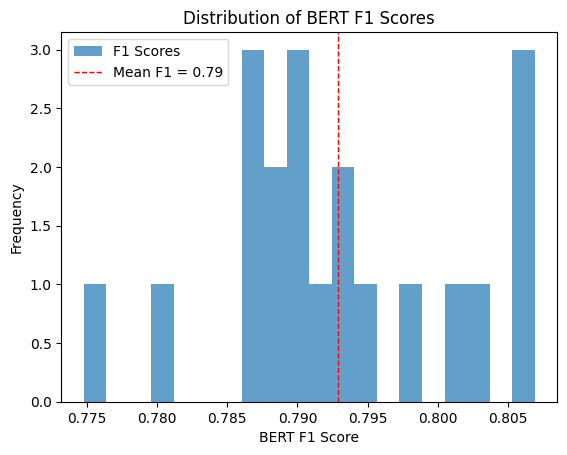

In [37]:
import matplotlib.pyplot as plt

plt.hist(dataframe['bert_f1'], bins=20, alpha=0.7, label='F1 Scores')
plt.axvline(mean_f1, color='red', linestyle='dashed', linewidth=1, label=f"Mean F1 = {mean_f1:.2f}")
plt.xlabel("BERT F1 Score")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of BERT F1 Scores")
plt.show()


In [38]:
import scipy.stats as stats

confidence = 0.95
f1_std = F1.std().item()
f1_se = f1_std / (len(F1) ** 0.5)
f1_ci = stats.norm.interval(confidence, loc=mean_f1, scale=f1_se)

print(f"95% Confidence Interval for F1: ({f1_ci[0]:.4f}, {f1_ci[1]:.4f})")


95% Confidence Interval for F1: (0.7891, 0.7967)
